<a href="https://colab.research.google.com/github/mrpintime/ConstraintsNN_V2/blob/main/ConstraintsNNV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConstraintsNNV2

In [1]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import pandas as pd

## Create sample of 20X20 seats

In [2]:
peoples = torch.arange(400)

# create 200 seating_arrngements
seating_arrngements = torch.tensor([torch.randperm(400).tolist() for x in range(1000)])
# seating_arr = torch.randperm(400).view((20,20))

In [3]:
seating_arrngements = seating_arrngements.view(1000,20,20)

In [4]:
# create groups
p = torch.ones((400)) / 400
g = torch.Generator().manual_seed(123)
pairs = torch.multinomial(input=p, num_samples=400,replacement=False, generator=g)
groups = [pairs[i:i+5].tolist() for i in range(0, 400, 5)]

In [5]:
len(groups)

80

In [6]:
def group_mutual(gp, num1, num2):
    for i in gp:
        if num1 in i and num2 in i:
            return True
        else:
            return False

In [7]:

list_of_conflicts = []

while len(list_of_conflicts) < 1:
    pairs_list = set()
    matrix = np.zeros((400, 400), dtype=int)

    while matrix.sum() < 600:
        num1 = np.random.choice(range(400))
        num2 = np.random.choice(range(400))

        if num1 == num2:
            continue
        gp_check = group_mutual(groups, num1, num2)
        pair = (num1, num2)
        if pair in pairs_list or gp_check:
            continue

        pairs_list.add(pair)
        matrix[num1, num2] = 1

    if not any(np.array_equal(matrix, conflict) for conflict in list_of_conflicts):
        list_of_conflicts.append(matrix)

<Axes: >

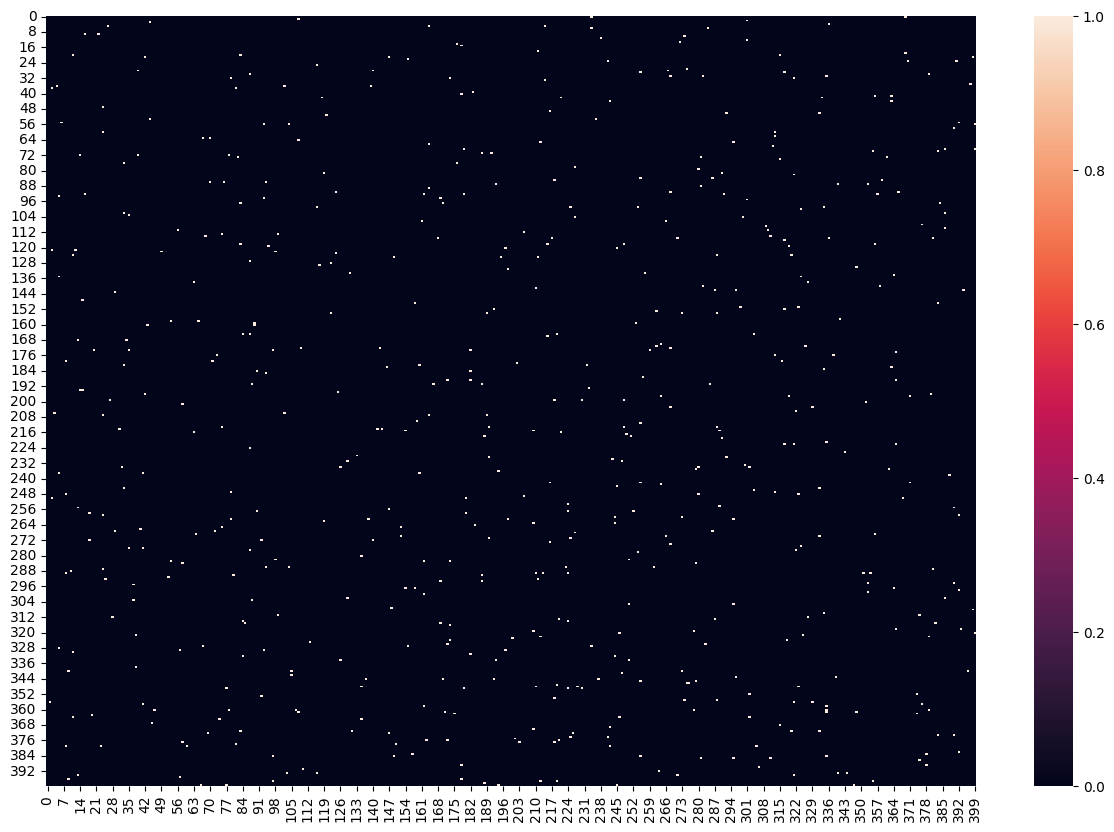

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(list_of_conflicts[0])

In [8]:
conflict_tensor = torch.tensor(list_of_conflicts[0])
conflict_tensor.dtype, conflict_tensor.size()

(torch.int64, torch.Size([400, 400]))

In [119]:
def calculate_conflict(seatings, conflict_tensor):
    conflicts = 0
    rows, cols = seatings.shape
    directions = [(-1, 0), (1, 0), (0, 1), (0, -1)]  # up, down, right, left

    for r in range(rows):
        for c in range(cols):
            current_seat = seatings[r, c]
            for dr, dc in directions:
                neighbor_row, neighbor_col = r + dr, c + dc
                if 0 <= neighbor_row < rows and 0 <= neighbor_col < cols:
                    neighbor_seat = seatings[neighbor_row, neighbor_col]
                    if conflict_tensor[current_seat, neighbor_seat] == 1:
                        conflicts += 1
    return conflicts


In [166]:
# xc = [calculate_conflict(seating_arrngements[x], conflict_tensor) for x in range(1000)]

In [165]:
# calculate_conflict(seating_arrngements[999], conflict_tensor)

In [12]:
def extract_GPmembers(num_seating_arr):
    gp_idxs = []
    for g in groups:
        idxs = []
        for m in g:
            idx = (seating_arrngements[num_seating_arr] == m).nonzero(as_tuple=True)
            idxs.append(idx)

        gp_idxs.append(idxs)
    return gp_idxs


In [13]:
def calculate_GPdensity(member_positions):
    distance = 0
    for idx, d in enumerate(member_positions):
        i, j = d
        for z in member_positions[idx+1:]:
            k, p = z
            distance += torch.sqrt((k - i) ** 2 + (p - j) ** 2)
    return distance/len(member_positions)


In [14]:
def OveralDistance(arrangement_num):
    gp_idxs = extract_GPmembers(arrangement_num)
    dist_perGP = [calculate_GPdensity(gp_idxs[x]).item() for x in range(80)]
    mean_dis = np.mean(dist_perGP)
    return mean_dis

In [15]:
# calculate overal distances of groups members in all 1000 arrangements
od = [OveralDistance(i) for i in range(1000)]
# calculate conflicts in all 200 arrangements
cc = [calculate_conflict(seating_arrngements[i], conflict_tensor) for i in range(1000)]

In [16]:
np.mean(od) , np.mean(cc)

(20.898660840618614, 5.706)

(array([  9.,  15.,  51., 120., 216., 257., 216.,  86.,  27.,   3.]),
 array([19.81608306, 20.02152008, 20.22695709, 20.43239411, 20.63783112,
        20.84326814, 21.04870515, 21.25414217, 21.45957918, 21.6650162 ,
        21.87045321]),
 <BarContainer object of 10 artists>)

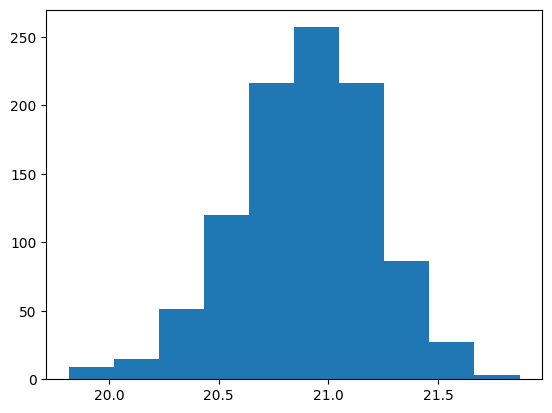

In [17]:
plt.hist(od)

(array([ 26.,  50., 250., 168., 281.,  98.,  99.,  12.,  15.,   1.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

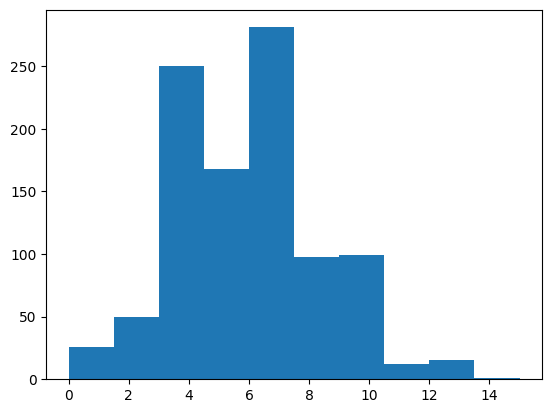

In [18]:
plt.hist(cc)

We should extract arrangement with good quality for learning

In [19]:
def extraction_arr():
    idx_list = []
    for idx, (i, x) in enumerate(zip(cc, od)):
        if i < np.mean(cc) and x < np.mean(od):
            idx_list.append(idx)
    return idx_list

In [20]:
lst = extraction_arr()

In [21]:
len(lst)

239

we use ~ 230 arrangements to train out network.

First we need to create `x_train` and `y_train`

In [22]:
ex = seating_arrngements[lst].view(len(lst),-1)

In [23]:
block_size = 3
x_train, y_train = [], []
for t in ex:
    X, Y = [], []
    context = [400] * block_size # 400 is for start of an arrangement and stop of it
    for ch in t.tolist() + [400]:
        X.append(context)
        Y.append(ch)
        context = context[1:] + [ch] # crop and append

    x_train.append(X)
    y_train.append(Y)

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

In [24]:
x_train.shape, y_train.shape

(torch.Size([239, 401, 3]), torch.Size([239, 401]))

In [25]:
x_train[0][-1], y_train[0][-1]

(tensor([136, 264,  55]), tensor(400))

In [26]:
x_train[1][-1], y_train[1][-1]

(tensor([148,   9, 314]), tensor(400))

In [27]:
X, Y = x_train.view(-1,3), y_train.view(-1,)

In [31]:
X.shape, Y.shape

(torch.Size([95839, 3]), torch.Size([95839]))

In [28]:
n1 = int(0.8*len(X))
n2 = int(0.9*len(X))

Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xte, Yte = X[n2:], Y[n2:]

In [29]:
Xtr.shape, Ytr.shape

(torch.Size([76671, 3]), torch.Size([76671]))

## MLP

In [32]:
g = torch.Generator().manual_seed(123)
#embedind layer
C = torch.randn(401, 20, generator=g) # we have 401 members
# first layer
H1 = torch.randn(60, 50, generator=g) * 0.2
B1 = torch.randn(50, generator=g) * 0.0
# second layer
H2 = torch.randn(50, 401, generator=g) * 0.2
B2 = torch.randn(401, generator=g) * 0.0

params = [C, H1, B1, H2, B2]
for p in params:
    p.requires_grad = True

In [157]:
for i in range(20):
    # forward pass
    embd = C[Xtr]
    out_1 = torch.tanh(embd.view(-1, 60) @ H1 + B1)
    logits = out_1 @ H2 + B2
    loss = F.cross_entropy(logits, Ytr)

    for p in params:
        p.grad = None
    loss.backward()
    for p in params:
        p.data += -10 * p.grad
    print(loss.item())



6.033479690551758
6.025753498077393
6.018749713897705
6.012397766113281
6.006635665893555
6.001404762268066
5.996652603149414
5.992331504821777
5.98839807510376
5.984811782836914
5.981540203094482
5.978549003601074
5.975809574127197
5.973298072814941
5.970989227294922
5.968863487243652
5.9669013023376465
5.965085506439209
5.963403701782227
5.96183967590332


In [158]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 20)
block_size = 3
out_list = []
for _ in range(10):
    out = []
    context = [400] * block_size  # Initialize with all zeros

    while len(out) < 400: # we have 400 unique members in seating arrangement
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ H1 + B1)
        logits = h @ H2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        if ix in out and ix != 400:
            continue
        out.append(ix)

    out_list.append(out)




In [159]:
def extract_GPmembers(arrs):
    gp_idxs = []
    for g in groups:
        idxs = []
        for m in g:
            idx = (arrs == m).nonzero(as_tuple=True)
            idxs.append(idx)
        gp_idxs.append(idxs)
    return gp_idxs

def calculate_GPdensity(member_positions):
    distance = 0
    for idx, d in enumerate(member_positions):
        i, j = d
        for z in member_positions[idx+1:]:
            k, p = z
            distance += torch.sqrt((k - i) ** 2 + (p - j) ** 2)
    return distance/len(member_positions)

def OveralDistance(arrangement):
    gp_idxs = extract_GPmembers(arrangement)
    dist_perGP = [calculate_GPdensity(gp_idxs[x]).item() for x in range(80)]
    mean_dis = np.mean(dist_perGP)
    return mean_dis

In [160]:
for i in range(10):
    arrs = np.array(out_list[i]).reshape(20,20)
    u, c = np.unique(arrs, return_counts=True)
    lost_num = list(set(np.arange(401)) - set(u))

    random.shuffle(lost_num)
    idx1 , idx2 = np.where(arrs == 400)
    for i, j in zip(idx1, idx2):
        arrs[i,j] = lost_num[0]
        del lost_num[0]



    o = OveralDistance(torch.tensor(arrs))
    c = calculate_conflict(arrs, conflict_tensor)

    print(o,c)

20.62940309047699 3
20.94017586708069 8
20.792422544956207 5
20.698360514640807 6
20.615017998218537 9
21.215077257156373 10
20.56584072113037 6
21.27582505941391 3
20.8045805811882 5
20.483757519721983 3


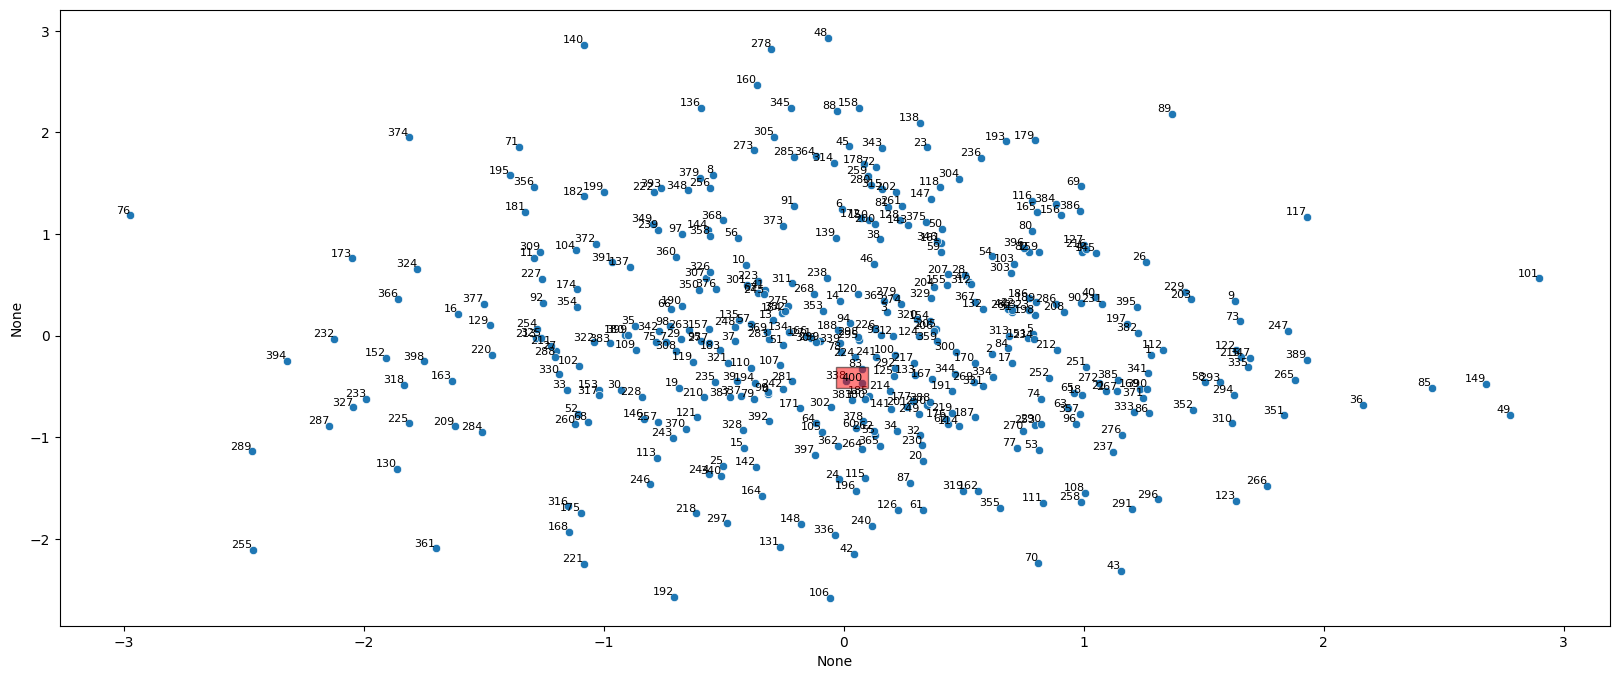

In [164]:
with torch.no_grad():
    plt.figure(figsize=(20,8))
    sns.scatterplot(x=C[:, 2], y=C[:, 3])
    for i in range(C.shape[0]):
        if i != 400:
            plt.text(C[i, 2], C[i, 3], i, fontsize=8, ha='right', va='bottom')
        else:
            plt.text(C[i, 2], C[i, 3], i, fontsize=8, ha='right', va='bottom',bbox=dict(facecolor='red', alpha=0.5))